In [6]:
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../RD-systems-and-test-benches/utils")
import model_fsolve as modf
import model_fsolve_v2 as modf2

import scipy.optimize as sco
import scipy.interpolate as sci

import hx_hydraulic as hxhy
import from_excel as fe
import data_plots as dplt

import fluids as fds
from CoolProp.CoolProp import PropsSI

import openpyxl as opxl
from sklearn.ensemble import RandomForestRegressor

import seaborn as sns
import os
import plotly.graph_objects as go


In [7]:
import utils.conversion as conv
import copy

In [8]:
path = r"G:\Drive partagés\Cercle Hard\R&D\Modèles numériques PVT\PVT-PL-model\Inputs"
file_name = "\V4.5_wo_interMPE.xlsx"
hw, par, cond = fe.initialize(path, file_name)
fe.change_temperature(cond, conv.to_K(-12))

fluid = {'name':'MPG','glycol_rate':0.4}

# tabl, res, PL, residuals = modf.PL_fsolve(par, cond) 

In [9]:
cond

{'eps': 0.001,
 'fluid': 'MPG',
 'glycol_rate': 0.4,
 'p': 150000.0,
 'T': 261.15,
 'Vdot': 500,
 'Dv': 0.0001388888888888889,
 'rho': 1047.1223352790403,
 'eta': 0.025505360943158834,
 'nu': 2.435757512169014e-05}

In [10]:
# df, PL, df_PL, residuals = modf.PL_fsolve(par, cond)

### Series for one flow rate but changing geometry

In [11]:
def find_other_dimension(Dh, side):
    """
    Calculate the height h of a rectangular tube given the hydraulic diameter Dh and width w.
    """
    if 2 * side <= Dh:
        raise ValueError("Invalid dimensions: 2 * w should be >  Dh")
    return (Dh * side) / (2 * side - Dh)

In [12]:
D_riser_range = np.array([1.4,1.2,1.,0.8,0.6]) * par['D_riser']

In [13]:
hw, par, cond = fe.initialize(path, file_name)
fe.change_temperature(cond, conv.to_K(-12))
N_panels = 6

Vdot = 600
Qtot = conv.convert_flow_rate(Vdot, 'L/h', 'm3/s')

h_riser_range = [find_other_dimension(D_riser, par['w_riser']) for D_riser in D_riser_range]
print(h_riser_range)
res_dict_h = {}

testings_path_list = [os.path.join(r"G:\Drive partagés\Cercle Hard\R&D\Modèles numériques PVT\PVT-PL-model\Thesis", file_name[1:-5] + f"change_h_riser_{int(h_riser*1000)}.xlsx") for h_riser in h_riser_range]

for i, h_riser in enumerate(h_riser_range):
    print('i ', i)

    # Change diameter

    hw.change_riser_height(h_riser)
    par = hw.make_dict()

    # Generate abaque

    list_Qin = np.linspace(0.05, 0.95, 7)*Qtot
    list_alpha = np.linspace(0.05, 0.95, 7)

    df_testings = fe.testing_series_Qmax(Qtot, list_Qin, list_alpha, par,cond)
    testings_path = testings_path_list[i]
    df_testings.to_excel(testings_path, index=False)

    # Run abaque for flow rate Vdot (L/h)

    testings_path = testings_path_list[i]

    df_testings = pd.read_excel(testings_path)
    DPin, DPout, DPx = modf2.transfer_func(df_testings)
    tabl, residuals = modf2.PL_fsolve_MPE(N_panels , conv.convert_flow_rate(Vdot, 'L/h', 'm3/s'), DPin, DPout, DPx)

    res_dict_h[h_riser] = {
                        'N_panels' : N_panels,
                        'Vdot' : Vdot,
                        'tabl' : copy.deepcopy(tabl),
                        'residuals' : copy.deepcopy(residuals)
                        }

    print('---')

[0.003919999999999998, 0.0027999999999999987, 0.0019999999999999996, 0.0014, 0.0009333333333333329]
i  0


100%|██████████| 49/49 [04:55<00:00,  6.03s/it]
g:\Mon Drive\GitHub\PVT-PL-model\model_fsolve_v2.py:431: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  Xsol = sc.fsolve(FUN, X0)


---
i  1


100%|██████████| 49/49 [04:48<00:00,  5.88s/it]
g:\Mon Drive\GitHub\PVT-PL-model\model_fsolve_v2.py:431: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  Xsol = sc.fsolve(FUN, X0)


---
i  2


100%|██████████| 49/49 [04:38<00:00,  5.68s/it]
g:\Mon Drive\GitHub\PVT-PL-model\model_fsolve_v2.py:431: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  Xsol = sc.fsolve(FUN, X0)


---
i  3


100%|██████████| 49/49 [04:40<00:00,  5.73s/it]
g:\Mon Drive\GitHub\PVT-PL-model\model_fsolve_v2.py:431: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  Xsol = sc.fsolve(FUN, X0)


---
i  4


100%|██████████| 49/49 [04:34<00:00,  5.60s/it]

---



g:\Mon Drive\GitHub\PVT-PL-model\model_fsolve_v2.py:431: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  Xsol = sc.fsolve(FUN, X0)


In [14]:
hw, par, cond = fe.initialize(path, file_name)
fe.change_temperature(cond, conv.to_K(-12))
N_panels = 6

Vdot = 600
Qtot = conv.convert_flow_rate(Vdot, 'L/h', 'm3/s')

w_riser_range = [find_other_dimension(D_riser, par['h_riser']) for D_riser in D_riser_range]
print(w_riser_range)
res_dict_w = {}

testings_path_list = [os.path.join(r"G:\Drive partagés\Cercle Hard\R&D\Modèles numériques PVT\PVT-PL-model\Thesis", file_name[1:-5] + f"change_h_riser_{int(w_riser*1000)}.xlsx") for w_riser in w_riser_range]

for i, w_riser in enumerate(w_riser_range):
    print('i ', i)

    # Change diameter

    hw.change_riser_width_and_update_N(w_riser)
    par = hw.make_dict()

    # Generate abaque

    list_Qin = np.linspace(0.05, 0.95, 7)*Qtot
    list_alpha = np.linspace(0.05, 0.95, 7)

    df_testings = fe.testing_series_Qmax(Qtot, list_Qin, list_alpha, par,cond)
    testings_path = testings_path_list[i]
    df_testings.to_excel(testings_path, index=False)

    # Run abaque for flow rate Vdot (L/h)

    testings_path = testings_path_list[i]

    df_testings = pd.read_excel(testings_path)
    DPin, DPout, DPx = modf2.transfer_func(df_testings)
    tabl, residuals = modf2.PL_fsolve_MPE(N_panels , conv.convert_flow_rate(Vdot, 'L/h', 'm3/s'), DPin, DPout, DPx)

    res_dict_w[w_riser] = {
                        'N_panels' : N_panels,
                        'Vdot' : Vdot,
                        'tabl' : copy.deepcopy(tabl),
                        'residuals' : copy.deepcopy(residuals)
                        }

    print('---')

[0.008909090909090898, 0.004666666666666664, 0.002799999999999999, 0.0017499999999999998, 0.0010769230769230767]
i  0


100%|██████████| 49/49 [00:30<00:00,  1.63it/s]
g:\Mon Drive\GitHub\PVT-PL-model\model_fsolve_v2.py:431: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  Xsol = sc.fsolve(FUN, X0)


---
i  1


100%|██████████| 49/49 [01:39<00:00,  2.03s/it]
g:\Mon Drive\GitHub\PVT-PL-model\model_fsolve_v2.py:431: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  Xsol = sc.fsolve(FUN, X0)


---
i  2


100%|██████████| 49/49 [04:31<00:00,  5.55s/it]
g:\Mon Drive\GitHub\PVT-PL-model\model_fsolve_v2.py:431: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  Xsol = sc.fsolve(FUN, X0)


---
i  3


100%|██████████| 49/49 [12:02<00:00, 14.75s/it]
g:\Mon Drive\GitHub\PVT-PL-model\model_fsolve_v2.py:431: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  Xsol = sc.fsolve(FUN, X0)


---
i  4


100%|██████████| 49/49 [26:46<00:00, 32.78s/it]

---



g:\Mon Drive\GitHub\PVT-PL-model\model_fsolve_v2.py:431: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  Xsol = sc.fsolve(FUN, X0)


In [20]:
hw, par, cond = fe.initialize(path, file_name)

option = 'COLD' + '_'

for (letter, res_dict, x_range) in zip(['h', 'w'], [res_dict_h, res_dict_w], [h_riser_range, w_riser_range]):

    res_dict['parameters'] = {
                                'par' : copy.deepcopy(par),
                                'cond' : copy.deepcopy(cond),
                                'N_panels' : N_panels,
                                'Vdot' : Vdot,
                                'Qtot' : Qtot,
                                'x_range' : x_range
                                }

    dp.write_pickle(r"G:\Drive partagés\Cercle Hard\R&D\Modèles numériques PVT\PVT-PL-model\Thesis", f"V4.5_multipanels_parametric_{option}res_dict_{letter}", res_dict)

1791.446854908915
2682.3875076884387
4646.911669957815
9235.17133528318
23791.51079690017


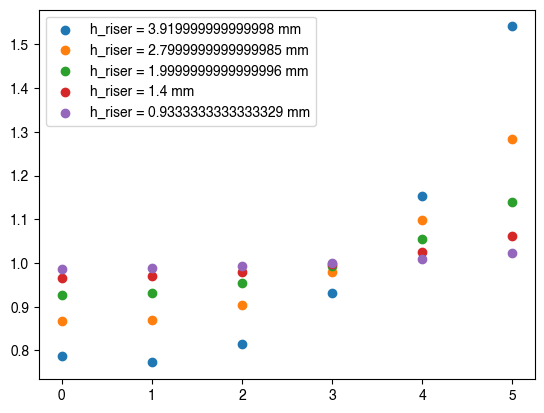

In [15]:
for key in res_dict_h.keys():
    # key = list(res_dict.keys())[1]
    tabl = res_dict_h[key]['tabl']
    plt.scatter(tabl.index, tabl['qx']/(tabl['qx'].sum()/N_panels), label=f'h_riser = {key*1000} mm')
    print(tabl['Pin'][0])

plt.legend()

2125.007182004474
3080.475508879896
4653.320948098868
7468.853922204319
14027.782407290955


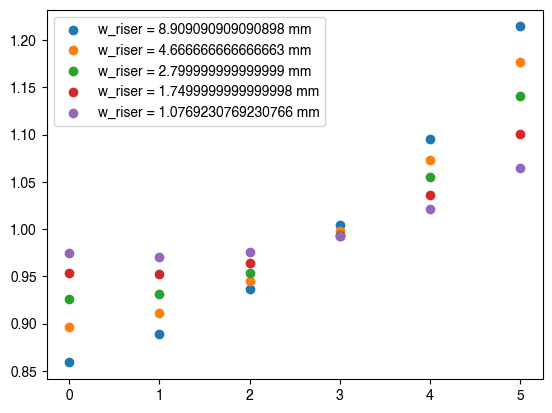

In [16]:
for key in res_dict_w.keys():
    # key = list(res_dict.keys())[1]
    tabl = res_dict_w[key]['tabl']
    plt.scatter(tabl.index, tabl['qx']/(tabl['qx'].sum()/N_panels), label=f'w_riser = {key*1000} mm')
    print(tabl['Pin'][0])

plt.legend()